In [2]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import itertools

In [3]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

# 1.PennyLane API

## Define a TOTAL Hamiltonian: H_p

First, given a series of Hamiltonian H1, H2, H3, a TOTAL H is defined as

H = c1 * H1 + c2 * H2 + c3 * H3

if H1, H2, H3 are all Pauli operators, then H is

In [3]:


H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)


  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


## Define a circuit based on H_p

Here, pennylane allows convert from Hamiltonian to qubit operator directly, using Trotter-Suzuki decomposition.
The resulting circuit is a time evolution operator U(H) with the Trotter-Suzuki decomposition, and contains only pauli gates.
here choose n=2

n=1

In [28]:

# First define a device with 2 qubits
wires = 2
dev = qml.device(name='default.qubit', wires=wires)

# Define the time evolution operator U(H) with the Trotter-Suzuki decomposition
t = 1 # parameter t in the time evolution operator
n = 2 # choose n = 2, larger n gives better approximation

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(hamiltonian=H, time=t, n=n)
    return [qml.expval(qml.PauliZ(i)) for i in range(wires)]    # get expectation values of PauliZ for each qubit

print(qml.draw(qnode=circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


n=2

In [3]:

# First define a device with 2 qubits
wires = 2
dev = qml.device(name='default.qubit', wires=wires)

# Define the time evolution operator U(H) with the Trotter-Suzuki decomposition
t = 1 # parameter t in the time evolution operator
n = 2 # choose n = 2, larger n gives better approximation

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(hamiltonian=H, time=t, n=n)
    return [qml.expval(qml.PauliZ(i)) for i in range(wires)]    # get expectation values of PauliZ for each qubit

print(qml.draw(qnode=circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


In [4]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


In [5]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


# Define a graph which is a direct mapping of an image

In [2]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

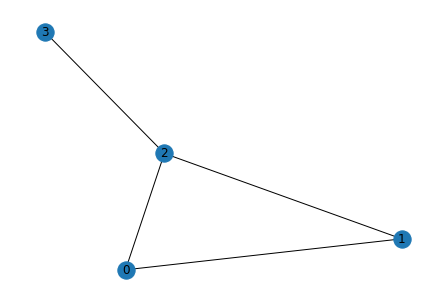

In [7]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

# Define a Hamiltonian H_p based on the graph and given task

In [29]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

TypeError: maxcut() got an unexpected keyword argument 'constrained'

# Define a circuit based on H_p

In [9]:
def qaoa_layer(gamma, alpha):
    """
    Building blocks of the QAOA ansatz.
    :param gamma: variational parameter for cost layer
    :param alpha: variational parameter for mixer layer
    :return:
    """
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [10]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [13]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

print(qml.draw(cost_function)(0.5))

TypeError: cost_function() missing 1 required positional argument: 'params'

In [18]:
print(qml.draw(qnode=circuit(params), expansion_strategy='device')())

AttributeError: 'NoneType' object has no attribute 'expansion_strategy'

In [12]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [14]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)


Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [15]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


In [20]:
print(qml.draw(qnode=probs, expansion_strategy='device')())

AttributeError: 'tensor' object has no attribute 'construct'

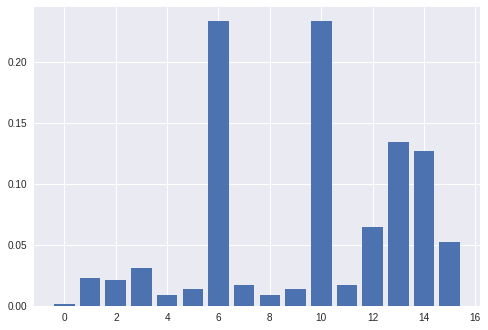

In [16]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

# 2. LOGISMOS

## LOGISMOS graph: simple, no geometric constraints

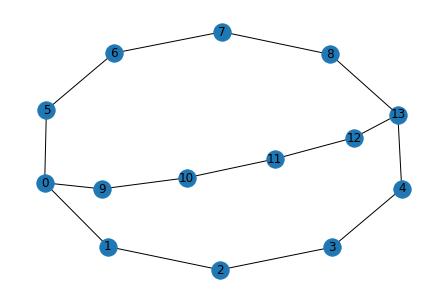

In [22]:
edges_logismos_1 = [
    (0,1), (0,5), (0,9),
    (1,2),
    (2,3),
    (3,4),
    (4,13),
    (5,6),
    (6,7),
    (7,8),
    (8,13),
    (9,10),
    (10,11),
    (11,12),
    (12,13),
]

graph_logismos = nx.Graph(edges_logismos_1)

nx.draw(graph_logismos, with_labels=True)
plt.show()


## Directed LOGISMOS graph: simple, no geometric constraints

In [1]:
G_logismos = nx.DiGraph()
G_logismos.add_edge('0', '1', capacity=100.0)
G_logismos.add_edge('0', '5', capacity=100.0)
G_logismos.add_edge('0', '9', capacity=100.0)

G_logismos.add_edge('1', '2', capacity=2.0)
G_logismos.add_edge('2', '3', capacity=1.0)
G_logismos.add_edge('3', '4', capacity=1.0)
G_logismos.add_edge('4', '13', capacity=100.0)            # sink
G_logismos.add_edge('5', '6', capacity=2.0)
G_logismos.add_edge('6', '7', capacity=2.0)
G_logismos.add_edge('7', '8', capacity=1.0)
G_logismos.add_edge('8', '13', capacity=100.0)        # sink
G_logismos.add_edge('9', '10', capacity=2.0)
G_logismos.add_edge('10', '11', capacity=2.0)
G_logismos.add_edge('11', '12', capacity=1.0)
G_logismos.add_edge('12', '13', capacity=100.0)           # sink

nx.draw(G_logismos, with_labels=True)

NameError: name 'nx' is not defined

In [61]:
flow_value, flow_dict = nx.maximum_flow(G_logismos, "0", "13")
flow_value

3.0

In [62]:
cut_value, partition = nx.minimum_cut(G_logismos, "0", "13")
reachable, non_reachable = partition


In [63]:
cutset = set()
for u, nbrs in ((n, G_logismos[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('11', '12'), ('3', '4'), ('7', '8')]


# CLASSICAL: Solved max-flow min-cut graph

## First example

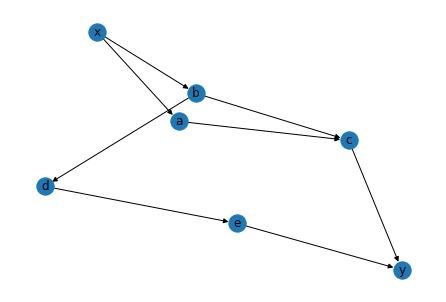

In [37]:
G = nx.DiGraph()
G.add_edge("x", "a", capacity=3.0)
G.add_edge("x", "b", capacity=1.0)
G.add_edge("a", "c", capacity=3.0)
G.add_edge("b", "c", capacity=5.0)
G.add_edge("b", "d", capacity=4.0)
G.add_edge("d", "e", capacity=2.0)
G.add_edge("c", "y", capacity=2.0)
G.add_edge("e", "y", capacity=3.0)
nx.draw(G, with_labels=True)

In [19]:
flow_value, flow_dict = nx.maximum_flow(G, "x", "y")
flow_value

3.0

In [20]:
cut_value, partition = nx.minimum_cut(G, "x", "y")
reachable, non_reachable = partition


In [21]:
cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('c', 'y'), ('x', 'b')]


## LOGISMOS, hard constraint

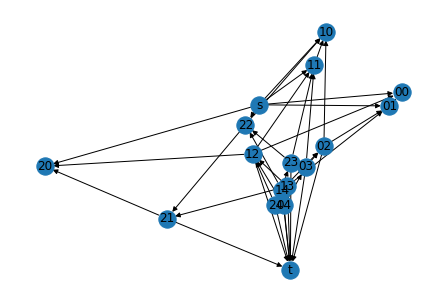

In [4]:
G = nx.DiGraph()
inf = 500
G.add_edge("04", "03", capacity=inf)
G.add_edge("03", "02", capacity=inf)
G.add_edge("02", "01", capacity=inf)
G.add_edge("01", "00", capacity=inf)
G.add_edge("14", "13", capacity=inf)
G.add_edge("13", "12", capacity=inf)
G.add_edge("12", "11", capacity=inf)
G.add_edge("11", "10", capacity=inf)
G.add_edge("24", "23", capacity=inf)
G.add_edge("23", "22", capacity=inf)
G.add_edge("22", "21", capacity=inf)
G.add_edge("21", "20", capacity=inf)

G.add_edge("04", "12", capacity=inf)
G.add_edge("03", "11", capacity=inf)
G.add_edge("02", "10", capacity=inf)

G.add_edge("14", "22", capacity=inf)
G.add_edge("13", "21", capacity=inf)
G.add_edge("12", "20", capacity=inf)

G.add_edge("14", "02", capacity=inf)
G.add_edge("13", "01", capacity=inf)
G.add_edge("12", "00", capacity=inf)

G.add_edge("24", "12", capacity=inf)
G.add_edge("23", "11", capacity=inf)
G.add_edge("22", "10", capacity=inf)

# From source to positively weighted nodes
# if a node has positive weight
# add an edge from source (s) to the node with capacity equal to +(the weight)
G.add_edge("s", "01", capacity=13)
G.add_edge("s", "11", capacity=13)
G.add_edge("s", "22", capacity=16)

# To avoid "empty set" error mention in original paper
# set weight of all base nodes to -1
# then add an edge from source (s) to those base node with capacity equal to -(the weight)=-(-1)=1
G.add_edge("s", "00", capacity=1)
G.add_edge("s", "10", capacity=1)
G.add_edge("s", "20", capacity=1)

# From negatively weighted nodes to sink
# if a node has negative weight
# add an edge from source (s) to the node with capacity equal to -(the weight)
G.add_edge("04", "t", capacity=10)
G.add_edge("03", "t", capacity=10)
G.add_edge("02", "t", capacity=18)

G.add_edge("14", "t", capacity=5)
G.add_edge("13", "t", capacity=1)
G.add_edge("12", "t", capacity=17)

G.add_edge("24", "t", capacity=10)
G.add_edge("23", "t", capacity=1)
G.add_edge("21", "t", capacity=3)

nx.draw(G, with_labels=True)

# rename nodes '00' to '1' and so on
G_integer = nx.convert_node_labels_to_integers(G, first_label=1, ordering="default", label_attribute='old_label')

### On original graph, 00-nn ordering

In [5]:
flow_value, flow_dict = nx.maximum_flow(G, "s", "t")
flow_value


3

In [7]:
cut_value, partition = nx.minimum_cut(G, "s", "t")
reachable, non_reachable = partition

cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('21', 't')]


In [8]:
partition

({'00', '01', '10', '11', '20', '21', '22', 's'},
 {'02', '03', '04', '12', '13', '14', '23', '24', 't'})

In [9]:
reachable

{'00', '01', '10', '11', '20', '21', '22', 's'}

In [32]:
!pwd

/nfs/s-iibi60/users/nale/iiai-projects/quantum-graph-remote


### On integer graph, 1-n ordering

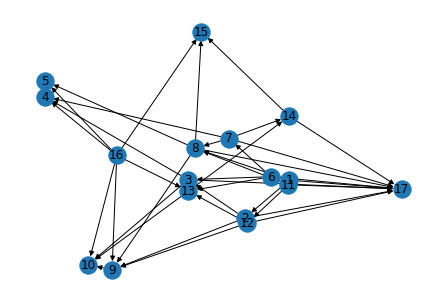

In [33]:
nx.draw(G_integer, with_labels=True)

# save G_integer graph to file for later use
nx.write_gml(G_integer, './graph_samples/logismos_2d_hardconstraints.gml')

In [19]:
# show all edges with capacity of G_integer graph
for edge in G_integer.edges(data=True):
    print(edge)


(1, 2, {'capacity': 500})
(1, 8, {'capacity': 500})
(1, 17, {'capacity': 10})
(2, 3, {'capacity': 500})
(2, 9, {'capacity': 500})
(2, 17, {'capacity': 10})
(3, 4, {'capacity': 500})
(3, 10, {'capacity': 500})
(3, 17, {'capacity': 18})
(4, 5, {'capacity': 500})
(6, 7, {'capacity': 500})
(6, 13, {'capacity': 500})
(6, 3, {'capacity': 500})
(6, 17, {'capacity': 5})
(7, 8, {'capacity': 500})
(7, 14, {'capacity': 500})
(7, 4, {'capacity': 500})
(7, 17, {'capacity': 1})
(8, 9, {'capacity': 500})
(8, 15, {'capacity': 500})
(8, 5, {'capacity': 500})
(8, 17, {'capacity': 17})
(9, 10, {'capacity': 500})
(11, 12, {'capacity': 500})
(11, 8, {'capacity': 500})
(11, 17, {'capacity': 10})
(12, 13, {'capacity': 500})
(12, 9, {'capacity': 500})
(12, 17, {'capacity': 1})
(13, 14, {'capacity': 500})
(13, 10, {'capacity': 500})
(14, 15, {'capacity': 500})
(14, 17, {'capacity': 3})
(16, 4, {'capacity': 13})
(16, 9, {'capacity': 13})
(16, 13, {'capacity': 16})
(16, 5, {'capacity': 1})
(16, 10, {'capacity': 

In [27]:
for node in G_integer.nodes(data=True):
    print(node)

(1, {'old_label': '04'})
(2, {'old_label': '03'})
(3, {'old_label': '02'})
(4, {'old_label': '01'})
(5, {'old_label': '00'})
(6, {'old_label': '14'})
(7, {'old_label': '13'})
(8, {'old_label': '12'})
(9, {'old_label': '11'})
(10, {'old_label': '10'})
(11, {'old_label': '24'})
(12, {'old_label': '23'})
(13, {'old_label': '22'})
(14, {'old_label': '21'})
(15, {'old_label': '20'})
(16, {'old_label': 's'})
(17, {'old_label': 't'})


In [29]:
cut_value, partition = nx.minimum_cut(G_integer, 16, 17)
reachable, non_reachable = partition

cutset = set()
for u, nbrs in ((n, G_integer[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[(14, 17)]


In [30]:
partition

({4, 5, 9, 10, 13, 14, 15, 16}, {1, 2, 3, 6, 7, 8, 11, 12, 17})

In [31]:
reachable

{4, 5, 9, 10, 13, 14, 15, 16}

## Krauss example

In [20]:
G = nx.DiGraph()
inf = 500
G.add_edge("x1", "x2", capacity=1) # (0, 1, 1.0)
G.add_edge("x1", "x3", capacity=2) # (0, 2, 2.0)
G.add_edge("x2", "x4", capacity=2) # (1, 3, 2.0)
G.add_edge("x3", "x4", capacity=1) # (2, 3, 1.0)

# new edge
# G.add_edge("x2", "x3", capacity=1)


In [21]:
flow_value, flow_dict = nx.maximum_flow(G, "x1", "x4")
flow_value


2

In [22]:
cut_value, partition = nx.minimum_cut(G, "x1", "x4")
reachable, non_reachable = partition

cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('x1', 'x2'), ('x3', 'x4')]


In [23]:
partition

({'x1', 'x3'}, {'x2', 'x4'})

# Function LOGISMOS graph

[[[  1   2   3   4   5]
  [  6   7   8   9  10]
  [ 11  12  13  14  15]
  [ 16  17  18  19  20]
  [ 21  22  23  24  25]
  [ 26  27  28  29  30]]

 [[ 31  32  33  34  35]
  [ 36  37  38  39  40]
  [ 41  42  43  44  45]
  [ 46  47  48  49  50]
  [ 51  52  53  54  55]
  [ 56  57  58  59  60]]

 [[ 61  62  63  64  65]
  [ 66  67  68  69  70]
  [ 71  72  73  74  75]
  [ 76  77  78  79  80]
  [ 81  82  83  84  85]
  [ 86  87  88  89  90]]

 [[ 91  92  93  94  95]
  [ 96  97  98  99 100]
  [101 102 103 104 105]
  [106 107 108 109 110]
  [111 112 113 114 115]
  [116 117 118 119 120]]]


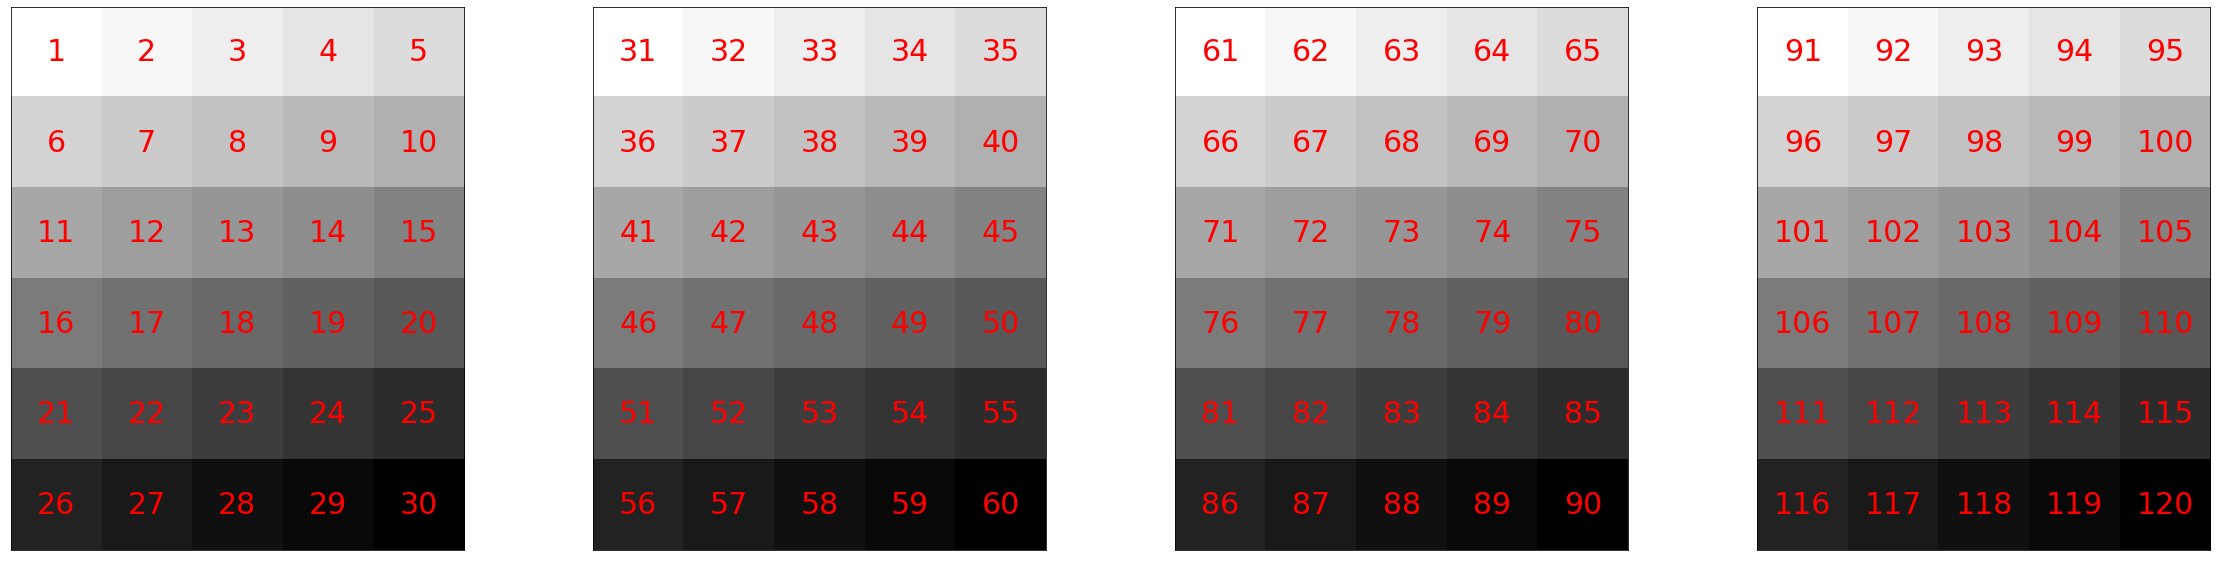

In [39]:
import math

cost_0 = [[ 1,  5,  9, 13],
          [ 2,  6, 10, 14],
          [ 3,  7, 11, 15],
          [ 4,  8, 12, 16]]
cost_1 = [[17, 21, 25, 29],
          [18, 22, 26, 30],
          [19, 23, 27, 31],
          [20, 24, 28, 32]]
cost_2 = [[33, 37, 41, 45],
          [34, 38, 42, 46],
          [35, 39, 43, 47],
          [36, 40, 44, 48]]
cost_3 = [[49, 53, 57, 61],
          [50, 54, 58, 62],
          [51, 55, 59, 63],
          [52, 56, 60, 64]]

cost = np.array([cost_0, cost_1, cost_2, cost_3])

def create_ordering_array(n_slice_y, n_col_x, n_height_z):
    flat_array = np.arange(1, n_slice_y * n_height_z * n_col_x + 1)
    # cost_array = flat_array.reshape(n_slice_y, n_col_x, n_height_z).transpose(0, 2, 1)

    cost_array = flat_array.reshape(n_slice_y, n_col_x, n_height_z)

    return cost_array

# Example usage:
cost = create_ordering_array(4, 6, 5)
print(cost)


# graph = build_graph_3d(n, n, n, cost)
# print(graph)

# create the 3D plot
dim_slice, dim_node, dim_col = cost.shape

# plot cost[0] as a 2D image
nrows = math.ceil(dim_slice/4)
figs, axs = plt.subplots(nrows=nrows, ncols=dim_slice, figsize=(dim_slice * 10, nrows * 10))

count_ax=0
for i in range(dim_slice):
    axs.flatten()[count_ax].imshow(cost[i], cmap=plt.cm.gray_r, interpolation='nearest')
    # show value in each cell of the matrix
    for x in range(cost[i].shape[0]):
        for y in range(cost[i].shape[1]):
            axs.flatten()[count_ax].text(y, x, '%.0f' % cost[i][x, y],
                               horizontalalignment='center',
                               verticalalignment='center',
                               color='red',
                               fontsize=30)
    axs.flatten()[count_ax].set_xticks([])
    axs.flatten()[count_ax].set_yticks([])
    count_ax += 1
    # ax.xlabel('columns')
    # ax.ylabel('')


plt.show()

In [35]:
cost[0]

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30]])

In [49]:
cost[0][:,2]

array([13, 14, 15, 16, 17, 18])

In [14]:
import random

def assign_random_element(cost):
    """
    Assigns a random element in each slice of cost to -1.

    Parameters:
        cost (ndarray): A 3-dimensional NumPy array of shape (nslice, nnode, ncol).

    Returns:
        ndarray: The updated cost array with one random element in each slice set to -1.
    """
    for i in range(cost.shape[0]): # iterate over slices
        for j in range(cost.shape[2]): # iterate over columns
            idx = random.randint(0, cost.shape[1]-1) # pick a random index
            cost[i, idx, j] = -1
    return cost

# Example usage:
cost_random = assign_random_element(cost)
print(cost_random)

[[[  1   6  11  16]
  [  2   7  -1  17]
  [  3   8  13  18]
  [  4   9  14  19]
  [ -1  -1  15  -1]]

 [[ 21  26  -1  36]
  [ -1  27  32  37]
  [ 23  28  33  -1]
  [ 24  29  34  39]
  [ 25  -1  35  40]]

 [[ 41  46  -1  -1]
  [ 42  -1  52  57]
  [ 43  48  53  58]
  [ 44  49  54  59]
  [ -1  50  55  60]]

 [[ 61  66  71  76]
  [ 62  67  -1  -1]
  [ -1  68  73  78]
  [ 64  -1  74  79]
  [ 65  70  75  80]]

 [[ 81  86  91  -1]
  [ 82  -1  92  97]
  [ -1  88  -1  98]
  [ 84  89  94  99]
  [ 85  90  95 100]]

 [[ -1 106 111 116]
  [102  -1 112 117]
  [103 108  -1  -1]
  [104 109 114 119]
  [105 110 115 120]]]


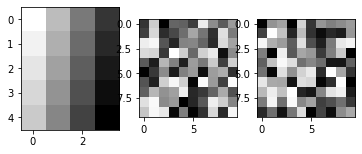

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create some sample grayscale images
image1 = np.random.rand(10, 10)
image2 = np.random.rand(10, 10)
image3 = np.random.rand(10, 10)

# Create three Axes objects using subplots()
fig, axs = plt.subplots(1, 3)

# Display the images on each Axes object using imshow()
axs[0].imshow(cost[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].imshow(image2, cmap=plt.cm.gray_r, interpolation='nearest')
axs[2].imshow(image3, cmap=plt.cm.gray_r, interpolation='nearest')

# Show the plot
plt.show()


In [32]:
axs[0].imshow(image1, cmap=plt.cm.gray_r, interpolation='nearest')

In [18]:
cost_flat = cost.flatten()
cost_flat

array([  1,   6,  11,  16,   2,   7,  12,  17,   3,   8,  13,  18,   4,
         9,  14,  19,   5,  10,  15,  20,  21,  26,  31,  36,  22,  27,
        32,  37,  23,  28,  33,  38,  24,  29,  34,  39,  25,  30,  35,
        40,  41,  46,  51,  56,  42,  47,  52,  57,  43,  48,  53,  58,
        44,  49,  54,  59,  45,  50,  55,  60,  61,  66,  71,  76,  62,
        67,  72,  77,  63,  68,  73,  78,  64,  69,  74,  79,  65,  70,
        75,  80,  81,  86,  91,  96,  82,  87,  92,  97,  83,  88,  93,
        98,  84,  89,  94,  99,  85,  90,  95, 100, 101, 106, 111, 116,
       102, 107, 112, 117, 103, 108, 113, 118, 104, 109, 114, 119, 105,
       110, 115, 120])

In [22]:
G=nx.DiGraph()

G.add_nodes_from(cost_flat)


G.nodes()


NodeView((1, 6, 11, 16, 2, 7, 12, 17, 3, 8, 13, 18, 4, 9, 14, 19, 5, 10, 15, 20, 21, 26, 31, 36, 22, 27, 32, 37, 23, 28, 33, 38, 24, 29, 34, 39, 25, 30, 35, 40, 41, 46, 51, 56, 42, 47, 52, 57, 43, 48, 53, 58, 44, 49, 54, 59, 45, 50, 55, 60, 61, 66, 71, 76, 62, 67, 72, 77, 63, 68, 73, 78, 64, 69, 74, 79, 65, 70, 75, 80, 81, 86, 91, 96, 82, 87, 92, 97, 83, 88, 93, 98, 84, 89, 94, 99, 85, 90, 95, 100, 101, 106, 111, 116, 102, 107, 112, 117, 103, 108, 113, 118, 104, 109, 114, 119, 105, 110, 115, 120))

In [24]:
x = 2
y = 2
z = 2


indices_list = []

for i in range(x):
    for j in range(y):
        for k in range(z):
            index = str(i) + str(j) + str(k)
            indices_list.append(index)

print(indices_list)

['000', '001', '010', '011', '100', '101', '110', '111']


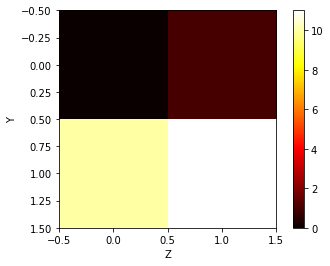

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x, y, and z represent the dimensions of the array
x = 2
y = 2
z = 2

indices_list = []

for i in range(x):
    for j in range(y):
        for k in range(z):
            index = int(str(i) + str(j) + str(k))
            indices_list.append(index)

# Reshape the indices into a 3D array
indices_array = np.array(indices_list).reshape(x, y, z)

# Plot the indices as a heatmap
plt.imshow(indices_array[0], cmap='hot', interpolation='nearest')
plt.colorbar()

# Add axis labels if desired
plt.xlabel('Z')
plt.ylabel('Y')

# Display the plot
plt.show()


In [22]:
i

0

# Generate random image

In [ ]:
# write a function that generate random 2-d image which has a background and a foreground, foreground is the upper half of the image define by parameter a. The boundary of background and foreground is on a arbitrary curve defined by parameter b. The background and foreground are both random noise. The noise is defined by parameter c. The noise is a random number between 0 and c. The image is a 2-d array of size 100x100. The function should return the image



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

def generate_image(n, c):
    # Create an array of zeros with shape (n, n)
    img = np.zeros((n, n))

    # Define the boundary between the object and the background
    y = int(n / 2)

    # Fill the object region with random intensities
    for i in range(n):
        for j in range(y, n):
            img[j, i] = random.uniform(0, 1)

    # Fill the background region with random intensities
    for i in range(n):
        for j in range(0, y):
            img[j, i] = random.uniform(0, 1)

    # Add random noise to the image
    noise = np.random.normal(0, c, (n, n))
    img = img + noise

    return img

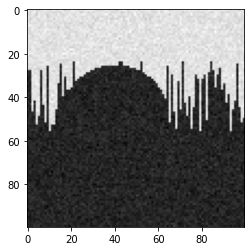

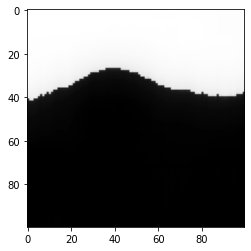

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

size = 100
starting_boundary = 0.4
radius = size/4
offset = 10
c = 0.5
smoothness = int(size/6)


img = np.zeros((size, size))

# Define the boundary between the object and the background
y = int(size*starting_boundary)

# random generate list of y that varies within y +/- smoothness
y_list = [random.randint(y-smoothness, y+smoothness) for i in range(size)]

# Fill the object region with random intensities
for i in range(size):
    for j in range(y_list[i], size):
        img[j, i] = random.uniform(0+offset, 1+offset)

# Fill the background region with random intensities
# for i in range(size):
#     for j in range(0, y):
#         img[j, i] = random.uniform(0, 1)

# Add a round shape whose center in the middle of the image starting_boundary*size and radius is 0.2*size
for i in range(size):
    for j in range(size):
        if (i-size*starting_boundary)**2 + (j-size/2)**2 < radius**2:
            img[j, i] = random.uniform(0+offset, 1+offset)


# Add random noise to the image
noise = np.random.normal(0, c, (size, size))
img = img + noise



# show s as image using matplotlib
plt.imshow(img, cmap='binary')
plt.show()

# denoise the image using median filter
from scipy import ndimage
import matplotlib.pyplot as plt

# Apply the median filter
im_med = ndimage.median_filter(img, size=int(size/3))
plt.imshow(im_med, cmap='binary')
plt.show()

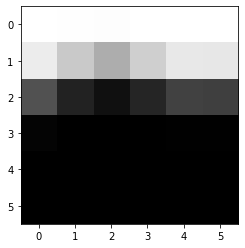

In [38]:
# resize img_med to 10x10
from skimage.transform import resize
img_med = resize(im_med, (6, 6), anti_aliasing=True)
plt.imshow(img_med, cmap='binary')
plt.show()


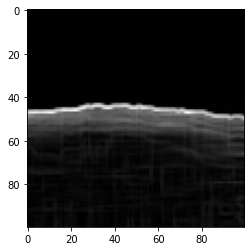

(100, 100)

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Load the numpy arra

def sobel(img):
    # Calculate the gradient
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # pad the image with adjacent values to avoid edge effects when convolving with the sobel filters
    im_med = np.pad(img, 1, mode='edge')

    grad_x = np.abs(convolve2d(im_med, sobel_x, mode='same'))
    grad_y = np.abs(convolve2d(im_med, sobel_y, mode='same'))

    # Combine the gradient images
    grad = np.sqrt(np.square(grad_x)
                   + np.square(grad_y)
                   )

    # remove the padding from the image to match the original image size before convolution
    grad = grad[1:-1, 1:-1]

    return grad


# Display the gradient image
plt.imshow(sobel(im_med), cmap='gray')
plt.show()

# shape of im_med
im_med.shape

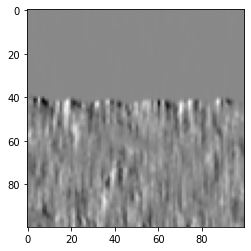

In [84]:
from scipy import ndimage
edges = ndimage.sobel(im_med)

# Display the edge image
plt.imshow(edges, cmap='gray')
plt.show()

In [45]:
from scipy import ndimage, datasets
import matplotlib.pyplot as plt
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = datasets.ascent()
result = ndimage.sobel(ascent)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()

ImportError: cannot import name 'datasets' from 'scipy' (/user/iibi/nale/.conda/envs/quantum-py38/lib/python3.8/site-packages/scipy/__init__.py)